# SEGMENT GPS Analysis

##### Notes
UTM  36North
EPSG:32636

In [179]:
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import os

import pandas as pd
import geopandas as gpd

import gpstools as gps

from shapely.geometry import LinearRing

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#from cartopy.io import LocatedImage
#from cartopy.io.shapereader import Reader
from cartopy.io.img_tiles import MapboxTiles

In [2]:
%matplotlib inline
%qtconsole
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 16

In [135]:
# Read list of SEGMENT & Nearby stations
df = pd.read_csv('segment_gps.txt',header=None, names=['site'])
seg_sites = list(df.site)
#NOTE: 'KARO' identifier already used in Australia

# Read list of SEGMENT stations
df = pd.read_csv('other_gps.txt',header=None, names=['site'])
other_sites = list(df.site)

In [112]:
dfS = gps.io.ungl.load_stations()
dfS.head()

,site,lat,lon,height,start,end
0,00NA,-12.4666,130.8440,104.851,2008-03-27,2017-01-21
1,01NA,-12.4782,130.9820,105.409,2008-04-08,2017-01-21
2,02NA,-12.3559,130.8817,117.652,2008-09-22,2016-12-31
3,1LSU,30.4074,-91.1803,-6.487,2003-04-23,2016-07-29
4,1NSU,31.7508,-93.0976,28.071,2004-01-16,2017-01-21


In [175]:
dfSeg = dfS[dfS.site.isin(seg_sites)]
dfSeg
gfSeg = gps.io.toGeoDataFrame(dfSeg)

dfOther = dfS[dfS.site.isin(other_sites)]
dfOther
gfOther = gps.io.toGeoDataFrame(dfOther)

In [114]:
### 31 Dec. 2014 Mw 5.1 
pSegment = np.array([33.8451, -9.86088]) 
pNEIC = np.array([33.863, -10.027]) 
pCMT = np.array([33.79, -9.73]) 

In [115]:
dfM = gps.io.ungl.load_midas()

In [116]:
dfM.head()

,site,version,start,end,years,epochs,epochs_good,pairs,east,north,...,e0,n0,u0,out_e,out_n,out_u,sig_e,sig_n,sig_u,nsteps
0,00NA,MIDAS4,2008.2355,2017.0568,8.8213,2645,2645,4750,35.845,58.510,...,-0.342,1.148,14.499,0.074,0.089,0.091,2.966,3.240,9.275,0
1,01NA,MIDAS4,2008.2683,2017.0568,8.7885,1585,1585,2813,35.493,59.453,...,0.676,2.161,-15.470,0.110,0.114,0.120,2.273,2.105,7.488,0
2,02NA,MIDAS4,2008.7255,2016.9993,8.2738,1906,1906,3378,35.889,59.791,...,-4.092,1.212,-6.671,0.087,0.073,0.081,2.503,2.768,8.395,0
3,1LSU,MIDAS4,2003.3073,2016.5749,13.2676,4339,3986,5213,-12.547,-0.285,...,1.566,-4.303,-10.141,0.054,0.062,0.070,4.197,3.199,9.805,5
4,1NSU,MIDAS4,2004.0411,2017.0568,13.0157,4314,4258,6487,-13.256,-0.224,...,-2.532,1.352,0.951,0.069,0.056,0.056,2.335,2.328,9.035,2


In [117]:
dfM.keys()

Index(['site', 'version', 'start', 'end', 'years', 'epochs', 'epochs_good',
       'pairs', 'east', 'north', 'up', 'err_e', 'err_n', 'err_u', 'e0', 'n0',
       'u0', 'out_e', 'out_n', 'out_u', 'sig_e', 'sig_n', 'sig_u', 'nsteps'],
      dtype='object')

## Extract Station between certain lat-lon range

In [118]:
subset = dfS.query('(-16 < lat < -6) and (30 < lon < 40)') #Extend East to get subandes stations
df = pd.merge(dfM, subset, how='inner', on=['site'])
# Additional subset to get same time range as PLUTONS stations
#df.query('(start >= 2010.2861) and (end <= 2015.1951)') #UTUR
# Doesn't work,,, for interseismic analysis consider UTUR start up to Pisagua EQ, however, MIDAS
# supposedly is insensitive to offsets, or actually removes them based on events in steps database

In [119]:
def crop_to_map(ax, gframe):
    ''' crop geopandas dataframe to map area'''
    minLon, maxLon, minLat, maxLat = ax.get_extent()
    gframe['lon'] = gframe.geometry.apply(lambda p: p.x)
    gframe['lat'] = gframe.geometry.apply(lambda p: p.y)
    crop = gframe.query('(@minLat < lat < @maxLat) and (@minLon < lon < @maxLon)') 
    return crop

In [171]:
def add_points_to_map(ax, gf, point=True, label=True, text='NAME', 
                      scatterArgs=dict(marker='o', c='k', s=10),
                      textArgs=dict(fontweight='normal')):
    ''' Assume Geodetic Lat/Lon'''
    
    crop = crop_to_map(ax,gf)
    
    if point:
        points = list(crop.geometry)
        lats = [point.y for point in points]
        lons = [point.x for point in points]
        ax.scatter(lons, lats, zorder=10, transform=ccrs.Geodetic(), 
                   **scatterArgs) 

    if label:
        for i,row in crop.iterrows():
            ax.text(row.geometry.x, row.geometry.y, row[text], transform=ccrs.Geodetic(),
                   **textArgs)


In [180]:
# Add overview Inset map
def polyFromCoords(mapextent):
    lons = mapextent[:2] + mapextent[:2][::-1]
    lats = (mapextent[2],)*2 + (mapextent[3],)*2
    coords = list(zip(lons, lats))
    boundary = LinearRing(coords)
    return boundary

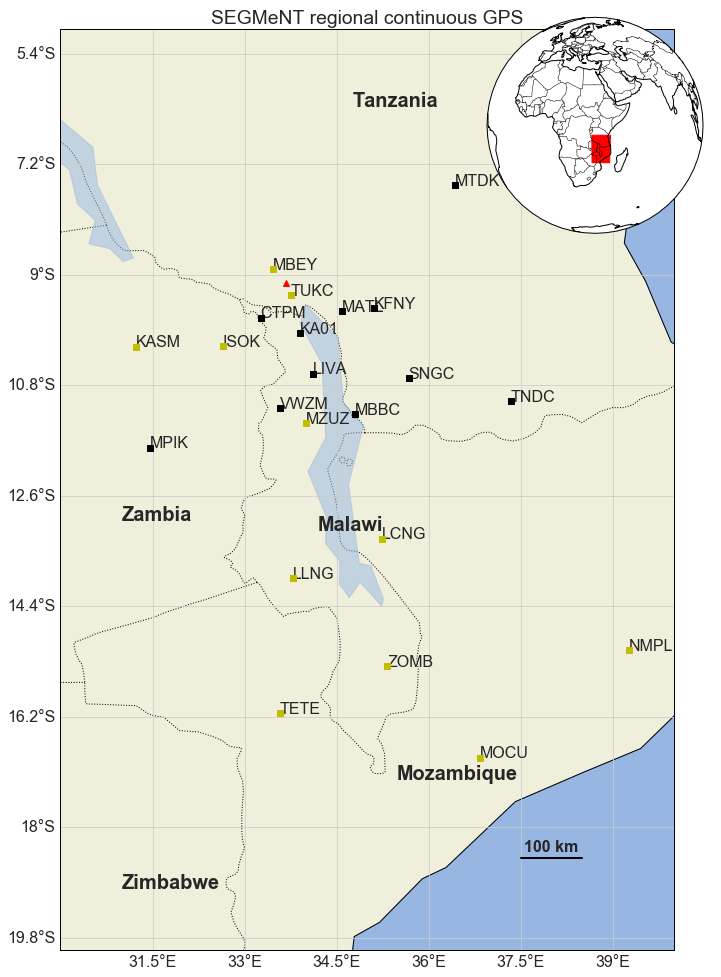

In [229]:
# Basic Map
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

fig = plt.figure(figsize=(11,17))
ax = plt.axes(projection=plot_CRS)
ax.set_extent([30, 40, -5, -20]) #W E N S 

add_points_to_map(ax, gfSeg, text='site', 
                  scatterArgs=dict(marker='s', color='k')) 

add_points_to_map(ax, gfOther, text='site', 
                  scatterArgs=dict(marker='s', color='y')) 

ax.plot(33.668, -9.135, 'r^', transform=geodetic_CRS, label='Rungwe Volcano')

#gf = gpd.read_file('/Users/scott/Downloads/ne_110m_populated_places/ne_110m_populated_places.shp')
#add_points_to_map(ax, gf)

gf = gpd.read_file('/Users/scott/Downloads/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# These are polygons, so convert to central point
tmp = gf.copy()
tmp['geometry'] = gf.geometry.centroid
textArgs = dict(fontweight='bold', fontsize=20)
add_points_to_map(ax, tmp, text='name', point=False,
                  textArgs=textArgs)
# Some countries missing. Add them
ax.text(31.0, -13.0, 'Zambia', **textArgs)
ax.text(31.0, -19.0, 'Zimbabwe', **textArgs)


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add scale bar
ax.plot([37.5, 38.5], [-18.5, -18.5],'k-',lw=2, transform=geodetic_CRS)
ax.text(38.0, -18.4,'100 km', fontweight='bold', ha='center', transform=geodetic_CRS)

# Add inset map
insetproj = ccrs.Orthographic(central_longitude=32.0, central_latitude=0)
pos = [0.65, 0.65, 0.3, 0.3]
axin = plt.axes(pos, projection=insetproj)
boundary = polyFromCoords(ax.get_extent())
feature = cfeature.ShapelyFeature([boundary], geodetic_CRS)
axin.add_feature(feature, facecolor='r', color='r')
axin.coastlines('110m')
axin.add_feature(borders, linewidth=0.5)

ax.set_title('SEGMeNT regional continuous GPS')

plt.savefig('segment_gps_map.pdf', bbox_inches='tight')

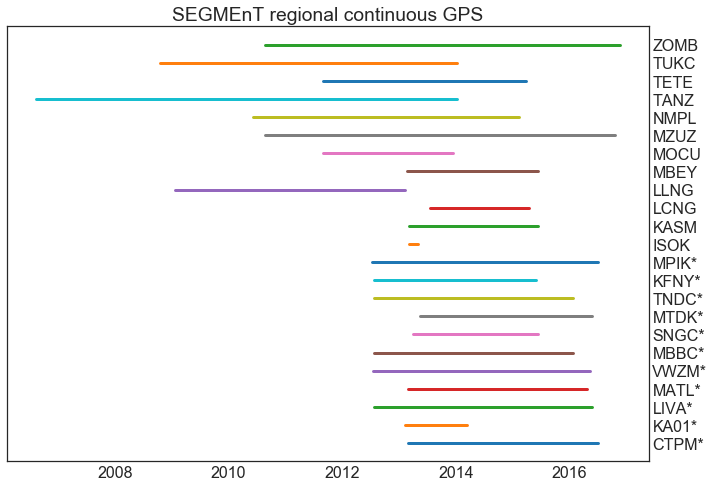

In [249]:
# Timeline of continuous GPS measurements on map
#eq = pd.to_datetime('2014-12-31')
df = pd.concat([dfSeg, dfOther], ignore_index=True)

fig,ax = plt.subplots(1,1,figsize=(11.5,8))

for i,row in df.iterrows():
    plt.plot([row.start, row.end], [i,i], lw=3)
plt.ylim(-1, len(df))
plt.title('SEGMEnT regional continuous GPS')
#plt.axvline(eq, linestyle='dashed', color='k', label='Mw 5.1')
plt.legend(loc='upper left')
# Add asterix to label of new SEGMEnT station
df.loc[df.site.isin(seg_sites), 'site'] = [x + '*' for x in seg_sites]
    
plt.yticks(df.index.values, df.site.values)
plt.tick_params(labelleft=False, labelright=True, bottom=True, top=True, right=True, left=True)

plt.savefig('segment_gps_timeline.pdf', bbox_inches='tight')

CTPM
CTPM already dowloaded... skipping
east Rate [mm/yr]=17.73119580227831
RMSE =  2.72497511323
KA01
east Rate [mm/yr]=20.360379951537325
RMSE =  2.44738419252
LIVA
east Rate [mm/yr]=21.472884490136995
RMSE =  2.64525458251
MATL
east Rate [mm/yr]=23.120813703828606
RMSE =  2.73462344775
VWZM
east Rate [mm/yr]=18.048452603090638
RMSE =  4.10367819405
MBBC
east Rate [mm/yr]=18.87325618858294
RMSE =  2.94090888689
SNGC
east Rate [mm/yr]=21.125042156078933
RMSE =  3.09603760042
MTDK
east Rate [mm/yr]=17.74234711581738
RMSE =  2.85728444088
TNDC
east Rate [mm/yr]=22.373855487836753
RMSE =  2.36378873684
KFNY
east Rate [mm/yr]=23.172220387233352
RMSE =  2.44558541524
MPIK
east Rate [mm/yr]=21.123033203196595
RMSE =  2.98062286205


NameError: name 'pltdate' is not defined

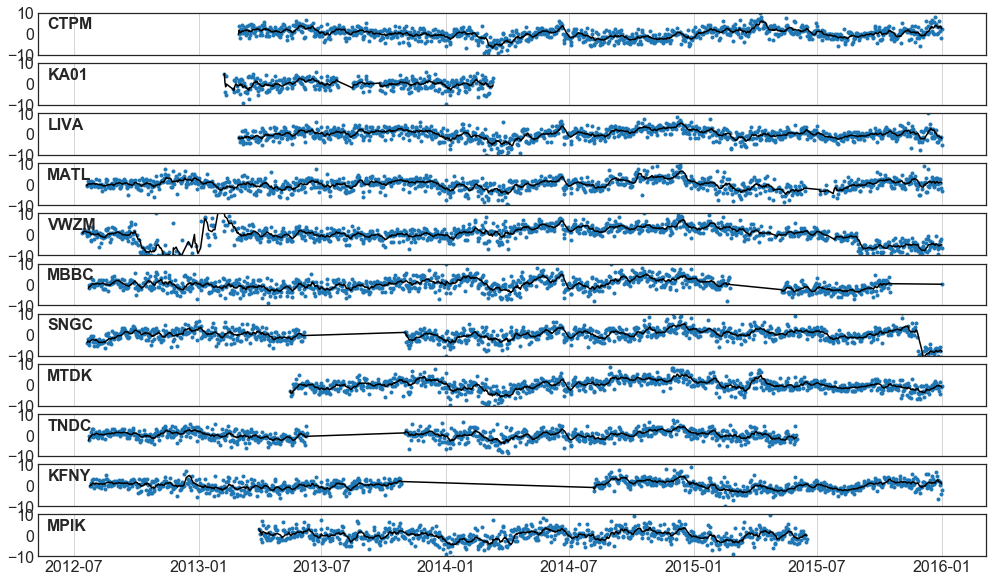

In [254]:
# Compare Vertical Components
# N-S profile of GPS stations that should show ETS event

sites = seg_sites

comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)

